In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session



/kaggle/input/asl-fingerspelling/supplemental_metadata.csv
/kaggle/input/asl-fingerspelling/character_to_prediction_index.json
/kaggle/input/asl-fingerspelling/train.csv
/kaggle/input/asl-fingerspelling/supplemental_landmarks/371169664.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/369584223.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1682915129.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/775880548.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2100073719.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1650637630.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1471096258.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/86446671.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/897287709.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/333606065.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2057261717.parquet
/kaggle/inpu

In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 28.0 MB/s eta 0:00:00


In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
import pandas as pd

csv_files = ['/kaggle/input/asl-fingerspelling/supplemental_metadata.csv', '/kaggle/input/asl-fingerspelling/train.csv']

dataframes = []
source_col = []

# Iterate through each CSV file
for idx, file in enumerate(csv_files):
    df = pd.read_csv(file)
    dataframes.append(df)
    source_col.extend([1 if idx == 0 else 2] * len(df))  # Assign 1 for the first file, 2 for the second file

dataset_df = pd.concat(dataframes, ignore_index=True)
dataset_df['source'] = source_col  # Add the source column to the concatenated DataFrame
dataset_df = dataset_df.sort_values('participant_id')

# Print the concatenated DataFrame
print(dataset_df)

print("Full train dataset shape is {}".format(dataset_df.shape))


                                             path     file_id  sequence_id  \
26088    supplemental_landmarks/897287709.parquet   897287709    293045148   
84778          train_landmarks/1021040628.parquet  1021040628   1737624109   
86667          train_landmarks/1099408314.parquet  1099408314   1224008370   
64463           train_landmarks/425182931.parquet   425182931   1131576821   
37403   supplemental_landmarks/1407656790.parquet  1407656790    627763041   
...                                           ...         ...          ...   
115365         train_landmarks/2026717426.parquet  2026717426   1184671927   
19924    supplemental_landmarks/680303484.parquet   680303484   1413112833   
31303   supplemental_landmarks/1112747136.parquet  1112747136   1671233100   
4108     supplemental_landmarks/193950599.parquet   193950599    695534533   
66402           train_landmarks/474255203.parquet   474255203     38217312   

        participant_id                         phrase  source  

In [5]:
dataset_df.to_excel('/kaggle/working/output.xlsx', index=False)

In [6]:
dataset_df.head()


,path,file_id,sequence_id,participant_id,phrase,source
26088,supplemental_landmarks/897287709.parquet,897287709,293045148,0,we dine out on the weekends,1
84778,train_landmarks/1021040628.parquet,1021040628,1737624109,0,techo-14/veera.puputti,2
86667,train_landmarks/1099408314.parquet,1099408314,1224008370,0,kimia/409161/sijoituskolikko,2
64463,train_landmarks/425182931.parquet,425182931,1131576821,0,5566 hellertown road,2
37403,supplemental_landmarks/1407656790.parquet,1407656790,627763041,0,machinery is too complicated,1


In [7]:
# Fetch sequence_id, file_id, phrase from first row
sequence_id, file_id, phrase = dataset_df.iloc[0][['sequence_id', 'file_id', 'phrase']]
print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")

In [8]:
# Fetch data from parquet file
sample_sequence_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
    filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))


In [9]:
# Function create animation from images.

matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)


In [10]:
# Extract the landmark data and convert it to an image using medipipe library.
# This function extracts the data for both hands.

mp_pose = mediapipe.solutions.pose
mp_hands = mediapipe.solutions.hands
mp_drawing = mediapipe.solutions.drawing_utils 
mp_drawing_styles = mediapipe.solutions.drawing_styles

def get_hands(seq_df):
    images = []
    all_hand_landmarks = []
    for seq_idx in range(len(seq_df)):
        x_hand = seq_df.iloc[seq_idx].filter(regex="x_right_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_right_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_right_hand.*").values

        right_hand_image = np.zeros((600, 600, 3))

        right_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        
        for x, y, z in zip(x_hand, y_hand, z_hand):
            right_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                right_hand_image,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        x_hand = seq_df.iloc[seq_idx].filter(regex="x_left_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_left_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_left_hand.*").values
        
        left_hand_image = np.zeros((600, 600, 3))
        
        left_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        for x, y, z in zip(x_hand, y_hand, z_hand):
            left_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                left_hand_image,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        images.append([right_hand_image.astype(np.uint8), left_hand_image.astype(np.uint8)])
        all_hand_landmarks.append([right_hand_landmarks, left_hand_landmarks])
    return images, all_hand_landmarks

In [11]:
# Get the images created using mediapipe apis
hand_images, hand_landmarks = get_hands(sample_sequence_df)
# Fetch and show the data for right hand
create_animation(np.array(hand_images)[:, 0])


In [12]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE


In [13]:
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]


In [14]:
FEATURE_COLUMNS = X + Y + Z

In [15]:
X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]


In [16]:
import os
import shutil
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import tensorflow as tf
from tqdm import tqdm

# Set length of frames to 128
FRAME_LEN = 128

# Create directory to store the new data
if not os.path.isdir("preprocessed"):
    os.mkdir("preprocessed")
else:
    shutil.rmtree("preprocessed")
    os.mkdir("preprocessed")

# Loop through each file_id
for file_id in tqdm(dataset_df.file_id.unique()):
    # Check if the file_id is from the supplemental data or the train data
    is_supplemental = (file_id in dataset_df.loc[dataset_df["source"] == 1, "file_id"].unique())
    
    # Parquet file name
    if is_supplemental:
        pq_file = f"/kaggle/input/asl-fingerspelling/supplemental_landmarks/{file_id}.parquet"
    else:
        pq_file = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"
    
    # Filter dataset_df and fetch entries only for the relevant file_id
    file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
    
    # Fetch the parquet file
    parquet_df = pq.read_table(pq_file, columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    
    # File name for the updated data
    tf_file = f"preprocessed/{file_id}.tfrecord"
    
    parquet_numpy = parquet_df.to_numpy()
    
    # Initialize the pointer to write the output of each `for loop` below as a sequence into the file.
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        # Loop through each sequence in the file
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            # Fetch sequence data
            frames = parquet_numpy[parquet_df.index == seq_id]
            
            # Calculate the number of NaN values in each hand landmark
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis=1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis=1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2 * len(phrase) < no_nan:
                features = {
                    FEATURE_COLUMNS[i]: tf.train.Feature(float_list=tf.train.FloatList(value=frames[:, i]))
                    for i in range(len(FEATURE_COLUMNS))
                }
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                features["source"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[1 if is_supplemental else 2]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)


100%|██████████| 121/121 [18:38<00:00,  9.25s/it]


In [17]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}


In [18]:
# Reference: https://www.kaggle.com/code/irohith/aslfr-transformer/notebook

# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

In [19]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

In [20]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    # Vectorize and add padding.
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    # Apply pre_process function to the landmarks.
    return pre_process(landmarks), phrase


In [21]:
tf_records = dataset_df.file_id.map(lambda x: f'/kaggle/working/preprocessed/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 121 TFRecord files.


In [22]:
batch_size = 64
train_len = int(0.8 * len(tf_records))

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()


In [23]:
# Assuming your dataset variable holds the CacheDataset object
for sequence, labels in train_ds.take(1):  # Read only one instance
    # Access and use the sequence data
    # `sequence` will be a tensor with shape (None, 128, 78) and dtype tf.float32
    sequence_data = sequence.numpy()  # Convert the tensor to a numpy array if needed
    
    # Access and use the labels or targets
    # `labels` will be a tensor with shape (None, None) and dtype tf.int32
    labels_data = labels.numpy()  # Convert the tensor to a numpy array if needed
    
    # Perform further processing or analysis with the data
    # Example: Print the shapes and data types of the sequence and labels
    print("Sequence shape:", sequence_data.shape)
    print("Sequence dtype:", sequence_data.dtype)
    print("Labels shape:", labels_data.shape)
    print("Labels dtype:", labels_data.dtype)
    print(labels_data)
    print(sequence_data)


Sequence shape: (64, 128, 78)
Sequence dtype: float32
Labels shape: (64, 64)
Labels dtype: int32
[[60 54 36 ... 59 59 59]
 [60 50 46 ... 59 59 59]
 [60 47 43 ... 59 59 59]
 ...
 [60 35 49 ... 59 59 59]
 [60 40  0 ... 59 59 59]
 [60 36 55 ... 59 59 59]]
[[[-6.5972537e-01  1.7138243e+00  1.9837328e+00 ...  3.8168299e-01
    6.7721891e-01 -2.7948139e+00]
  [-8.4286362e-01  1.6150895e+00  2.4175322e+00 ...  3.9037406e-01
    6.8504041e-01 -2.7092252e+00]
  [-4.8128819e-01  1.5642165e+00  2.3514466e+00 ...  3.8736209e-01
    6.7135841e-01 -2.8545578e+00]
  ...
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.2864568e-01
    7.5024766e-01 -2.7257924e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.2835259e-01
    7.4986869e-01 -2.7440813e+00]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  2.2766727e-01
    7.4547595e-01 -2.8217130e+00]]

 [[-2.5595725e-03  2.4151063e+00  2.4917696e+00 ...  4.1182137e-01
    7.0851225e-01 -3.3271692e+00]
  [-1.8613313e-01  2.6242692e+00

In [24]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)


In [25]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [26]:
# Customized to add `training` variable
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

In [27]:
# Customized to add edit_dist metric and training variable.
# Reference:
# https://www.kaggle.com/code/irohith/aslfr-transformer/notebook
# https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [28]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=60, target_end_token_idx=61
    ):
        """Displays a batch of outputs after every 4 epoch

        Args:
            batch: A test batch
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 4 != 0:
            return
        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")

In [29]:
# Transformer variables are customized from original keras tutorial to suit this dataset.
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

batch = next(iter(valid_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>']
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)


optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(train_ds, validation_data= valid_ds, callbacks=[display_cb], epochs=24)

Epoch 1/24
   1093/Unknown - 187s 150ms/step - loss: 1.0871 - edit_dist: 1.0558target:     <a touchdown in the last minute>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the touthe the the the therestherespenge>

target:     <the postal service is very slow>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the areangeringe the the thestheresitese>

target:     <all together in one big pile>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the areange thinge the therestheresitese>

target:     <vote according to your conscience>PPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the prearinge the there therererery>

target:     <rent is paid at the beginning of the month>PPPPPPPPPPPPPPPPPPPP
prediction: <the areange thinge the therestheresitese>

target:     <the king sends you to the tower>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the touthe the the the therestherespenge>

target:     <the high waves will swamp us>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <the porerere the the the wingerengeren

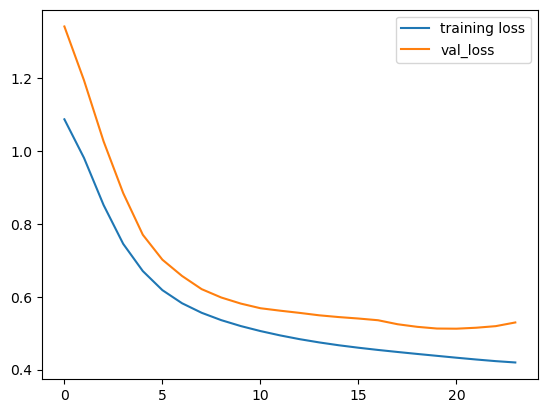

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'val_loss'])


In [31]:
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()
        self.target_start_token_idx = start_token_idx
        self.target_end_token_idx = end_token_idx
        # Load the feature generation and main models
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, len(FEATURE_COLUMNS)], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs, training=False):
        # Preprocess Data
        x = tf.cast(inputs, tf.float32)
        x = x[None]
        x = tf.cond(tf.shape(x)[1] == 0, lambda: tf.zeros((1, 1, len(FEATURE_COLUMNS))), lambda: tf.identity(x))
        x = x[0]
        x = pre_process(x)
        x = x[None]
        x = self.model.generate(x, self.target_start_token_idx)
        x = x[0]
        idx = tf.argmax(tf.cast(tf.equal(x, self.target_end_token_idx), tf.int32))
        idx = tf.where(tf.math.less(idx, 1), tf.constant(2, dtype=tf.int64), idx)
        x = x[1:idx]
        x = tf.one_hot(x, 59)
        return {'outputs': x}
    
tflitemodel_base = TFLiteModel(model)


In [32]:
model.save_weights("model.h5")

In [33]:
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflitemodel_base)
keras_model_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]#, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = keras_model_converter.convert()
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)
    
infargs = {"selected_columns" : FEATURE_COLUMNS}

with open('inference_args.json', "w") as json_file:
    json.dump(infargs, json_file)


In [34]:
!zip submission.zip  './model.tflite' './inference_args.json'

  adding: model.tflite (deflated 18%)
  adding: inference_args.json (deflated 85%)


In [35]:
interpreter = tf.lite.Interpreter("model.tflite")

REQUIRED_SIGNATURE = "serving_default"
REQUIRED_OUTPUT = "outputs"

with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    character_map = json.load(f)
rev_character_map = {j:i for i,j in character_map.items()}

found_signatures = list(interpreter.get_signature_list().keys())

if REQUIRED_SIGNATURE not in found_signatures:
    raise KernelEvalException('Required input signature not found.')

prediction_fn = interpreter.get_signature_runner("serving_default")
output = prediction_fn(inputs=batch[0][0])
prediction_str = "".join([rev_character_map.get(s, "") for s in np.argmax(output[REQUIRED_OUTPUT], axis=1)])
print(prediction_str)


804-818-81
